In [1]:
import pandas as pd
import numpy as np
from functions import disparity_filter,disparity_filter_alpha_cut
from matplotlib import pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import math
import random
from collections import Counter
from tabulate import tabulate
import re
import urllib.request
from urllib.error import HTTPError
#import imdb
from community import community_louvain
import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

# 1. Preparing the Network

In [25]:
links = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\links.csv')
movies = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\movies.csv')
ratings = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\ratings.csv')
tags = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\tags.csv')

### Include the High Rankings

The data has all the ratings from 1 to 5 but we are only interested in ratings 4 and 5 since this is kind of a recommendation network and if a user has rated a movie low then he/she would not recommend it.

In [26]:
ratings = ratings[ratings['rating'].isin([4,5])]

### Creating Raw Network

In [9]:
userIds = ratings['userId'].unique()
movieIds = ratings['movieId'].unique()

In [10]:
# Create both type of dictionaries
users_movies_dict = {}

for u in userIds:
    users_movies_dict[u] = list(ratings[ratings['userId']==u]['movieId'])
    
movies_users_dict = {}

for m in movieIds:
    movies_users_dict[m] = list(ratings[ratings['movieId']==m]['userId'])



In [11]:
nodes_w = {}


for u in userIds:
    for n1 in users_movies_dict[u] :
        for n2 in users_movies_dict[u]:
            if n1 > n2:
                if (n1,n2) in nodes_w:
                    nodes_w[(n1,n2)] += 1
                else:
                    nodes_w[(n1,n2)] = 1            

Basic Information about raw network

In [8]:
print('Number of Nodes:',len(movies))
print('Number of Edges:',len(nodes_w))

Number of Nodes: 9742
Number of Edges: 2347504


In [9]:
edges_w = [(k[0],k[1],v) for k,v in nodes_w.items()]

In [10]:
G = nx.Graph()
G.add_weighted_edges_from(edges_w)

### Filtering the Network

Since the network is highly densed, here we use disparity_filter to get the high wighted edges and reduce the number of edges.

In [11]:
G = disparity_filter(G)
G= disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or')

In [15]:
# nx.write_gml(G, "D:\\DTU\\Large Files\\Social Graphs\\G_project.edgelist")

In [14]:
G = nx.read_gml( "D:\\DTU\\Large Files\\Social Graphs\\G_project.edgelist")

#### Filter Dataframes

Since we used a filtering algorithm, some of the nodes are removed from the network and we have to remove them from all of our dataframes as well.

In [40]:
nodes_filtered = list(G.nodes)
nodes_filtered = [int(i) for i in nodes_filtered]

links = links[links['movieId'].isin( nodes_filtered )]
movies = movies[movies['movieId'].isin( nodes_filtered )]
ratings = ratings[ratings['movieId'].isin( nodes_filtered )]
tags = tags[tags['movieId'].isin( nodes_filtered )]

In [42]:
#Write to csv

# links.to_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\filtered_links.csv', index=False)
# movies.to_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\filtered_movies.csv', index=False)
# ratings.to_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\filtered_ratings.csv', index=False)
# tags.to_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\filtered_tags.csv', index=False)

### Adding Attributes

#### Year of the Movie

The years are in the title of each movie in parentheses, so by using regex we get the year for each movie.

In [43]:
years = []

for m in movies['title']:
    try:
        year = re.findall('\((\d\d\d\d)\)', str(m))[0]
    except:
        year = 0
    years.append(year)
         
movies['year'] = years
movies['year'] = movies['year'].astype(int)

#### Average Rating

We can add the average rating of each movie and add it as a column to our main data frame. As we are considering the high ranks (4 & 5), then the average ratings are all above 4.

In [44]:
movies_avg_rating = ratings.groupby('movieId')['rating'].mean().reset_index()
movies['average_rating'] = list(movies_avg_rating['rating'])

#### Degree

In [45]:
movies['degree'] = [G.degree(n) for n in sorted(list(G.nodes()))]

#### Genres

One movie can belong to different genres. They are all in the same column separeted by '|' so we try to get get a list of genres for each movie and put it into a column called 'genres_split'

In [ ]:
movies['genres_split'] = movies['genres'].str.split('|')

### Web Scraping

In order to enrich our data, we need to do web scraping to get the storyline (summary), country and runtime (duration of the movie) of each movie. Here we can use their IMDbId and get help from IMDB package to fetch the data.

#### Storylines

In [1]:
### Scraping storylines
# Takes a long time to run (about 80min) - Instead read movies_2.csv

## See what info imdb package has of the movies
#ia.get_movie_infoset()

## Create new empty column for storylines
movies["Storyline"] = ""
ia = imdb.IMDb()

## Going trhough all movies 
for mid in movies["movieId"]:
    # Get imdbId
    imdbid = links.loc[links["movieId"]==mid, "imdbId"].item()
    try:
        movie = ia.get_movie("0"+str(imdbid), info = 'plot')
        movie.infoset2keys
        storyline = movie['plot'][0]
    except:
        storyline = ""
    # Add storyline to movies dataframe
    movies.loc[movies["movieId"]==mid, "Storyline"] = storyline

### Save movies dataframe to csv
#movies.to_csv('movies_2.csv', index=False)

# + Country and Amount of sale (revenue) and Duration
# Goofs? amount

In [46]:
### Reading movies data set with storylines
movies_ws = pd.read_csv('movies_2.csv')

#### Country

In [65]:
ia = imdb.IMDb()
imdbid = links.loc[links["movieId"]==3, "imdbId"].item()
#infoneeded = 'release dates' #til country
infoneeded = 'technical' #til duration
movie = ia.get_movie("0"+str(imdbid), info = infoneeded)
#movie.infoset2keys
print(movie[infoneeded]['runtime'][0])
int(movie[infoneeded]['runtime'][0].split('(')[1].split(" ")[0])
#country = movie[infoneeded][0].split(':')[0]
#country

1 hr 41 min (101 min)


101

In [2]:
### Scraping Country
# Takes a long time to run (about 80min) - Instead read movies_wc.csv

## Create new empty column for storylines
movies_ws["Country"] = ""
ia = imdb.IMDb()
infoneeded = 'release dates' # For country (where first released)

## Going through all movies 
for mid in movies_ws["movieId"]:
    # Get imdbId
    imdbid = links.loc[links["movieId"]==mid, "imdbId"].item()
    try:
        movie = ia.get_movie("0"+str(imdbid), info = infoneeded)
        country = movie[infoneeded][0].split(':')[0]
    except:
        country = ""
    # Add storyline to movies dataframe
    movies_ws.loc[movies_ws["movieId"]==mid, "Country"] = country

### Save movies dataframe to csv
movies_ws.to_csv('movies_wc.csv', index=False)


In [66]:
### Reading movies data set with country
movies_wc = pd.read_csv('movies_wc.csv')

#### Runtime

In [3]:
### Scraping Runtime
# Takes a long time to run (about 115min) - Instead read movies_final.csv

## Create new empty column for storylines
movies_wc["Runtime"] = ""
ia = imdb.IMDb()
infoneeded = 'technical' #til duration

## Going trhough all movies 
for mid in movies_wc["movieId"]:
    # Get imdbId
    imdbid = links.loc[links["movieId"]==mid, "imdbId"].item()
    try:
        movie = ia.get_movie("0"+str(imdbid), info = infoneeded)
        runtime = int(movie[infoneeded]['runtime'][0].split('(')[1].split(" ")[0])
    except:
        runtime = 0
    # Add storyline to movies dataframe
    movies_wc.loc[movies_wc["movieId"]==mid, "Runtime"] = runtime

### Save movies dataframe to csv
movies_wc.to_csv('movies_final.csv', index=False)

#### Genres

Here we create a separeted dataframe for genres. If a movie has multiple genres, then it would be duplicated into different rows, each row having just one genre.

In [29]:
movies['genres_split'] = movies['genres'].str.split('|')
movies_genres_df = movies.explode('genres_split')
movies_genres_df = movies_genres_df[['movieId','title','genres_split','year','average_rating','degree','Runtime','Country','Storyline']]

In [30]:
# Write to csv
# movies_genres_df.to_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\movies_genres_df.csv', index=False)

### Load all the Datasets

The data from previous parts have been saved into some files and by running the code below we can get all the data needed so that we would not run the previous parts again.

In [15]:
movies = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\movies_final.csv')
movies_genres_df  = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\movies_genres_df.csv')
G = nx.read_gml( "D:\\DTU\\Large Files\\Social Graphs\\G_project.edgelist")
links = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\filtered_links.csv')
ratings = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\filtered_ratings.csv')
tags = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\filtered_tags.csv')

G = nx.relabel_nodes(G, lambda x: int(x))
movies['genres_split'] = movies['genres'].str.split('|')

In [25]:
movies.loc[747,'title'] = 'Raiders of the Lost Ark (1989)'

# 2. Network Analysis

In [3]:
N = G.number_of_nodes()
L = G.number_of_edges()
print('Number of Nodes:',N)
print('Number of Edges:',L)

Number of Nodes: 5760
Number of Edges: 1472512


As we can see, by implementing the disparity filter, out of 9742 nodes, 3982 nodes had 0 edges and thus removed from the network.

#### Power Law

In [6]:
import powerlaw

print('Degree Exponent:')
print('Total Degree:',powerlaw.Fit([G.degree(n) for n in G.nodes()]).alpha)

Degree Exponent:
Calculating best minimal value for power law fit
Total Degree: 3.7905687135021355


We can see that the alpha is higher than 3.

#### Degree Distribution

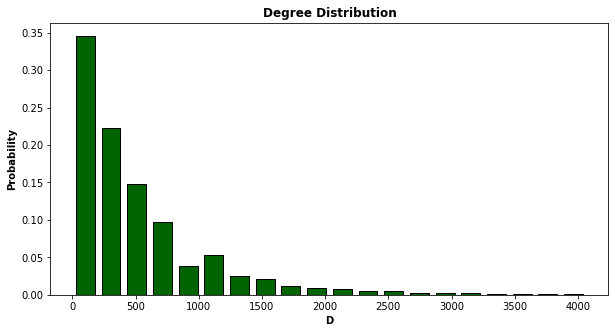

In [26]:
degrees = [G.degree(n) for n in G.nodes()]

n,bins = np.histogram(degrees,bins=20)

sum_degrees = np.sum(n)
prob = n/sum_degrees
max_prob = np.max(prob)

center = (bins[:-1] + bins[1:]) / 2

fig = plt.figure(figsize = (10, 5))

plt.bar(center,prob,width=150,  edgecolor='black',color='darkgreen')
plt.title("Degree Distribution", fontweight='bold')
plt.xlabel("D", fontweight='bold')
plt.ylabel("Probability", fontweight='bold')
plt.show()


Most of the nodes have few degrees but we can see some nodes with more than 4000 edges.

In [28]:
BA = nx.Graph()
BA.add_edges_from([(1, 2)])

def add_nodes_BA(G,n):
    
    starting_node = np.max(list(G.nodes()))+1

    for source in range(starting_node,n+1):

        all_nodes = []

        for e in list(G.edges()):
            all_nodes.append(e[0]) 
            all_nodes.append(e[1]) 

        target = random.choice(all_nodes)

        G.add_edges_from([(source,target)])
#----------------------------------------------    
    
add_nodes_BA(G=BA,n=N)



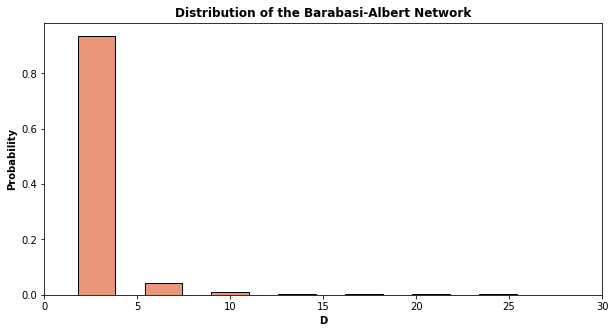

In [29]:
BA_degrees = [BA.degree(n) for n in BA.nodes()]
BA_n,BA_bins = np.histogram(BA_degrees,bins=40)
BA_sum_degrees = np.sum(BA_n)
BA_prob = BA_n/BA_sum_degrees
BA_max_prob = np.max(BA_prob)
BA_center = (BA_bins[:-1] + BA_bins[1:]) / 2

fig = plt.figure(figsize = (10, 5))

plt.bar(BA_center,BA_prob,width=2,edgecolor='black',color='darksalmon')
plt.title("Distribution of the Barabasi-Albert Network", fontweight='bold')
plt.xlabel("D", fontweight='bold')
plt.ylabel("Probability", fontweight='bold')
plt.xlim((0,30))
plt.show()

#### Average Degree 

Our network:

In [17]:
K = np.mean(degrees)
print('Mean Degrees:',K)

K_std = np.std(degrees)
print('Standard Deviation of Degrees:',K_std)

K_min = np.min(degrees)
print('Minimum of Degrees:',K_min)

K_max = np.max(degrees)
print('Maximum of Degrees:',K_max)

K_median = np.median(degrees)
print('Median of Degrees:',K_median)

Mean Degrees: 511.2888888888889
Standard Deviation of Degrees: 546.4780860086288
Minimum of Degrees: 1
Maximum of Degrees: 4067
Median of Degrees: 329.0


Barabasi-Albert network:

In [22]:
K = np.mean(BA_degrees)
print('Mean Degrees:',K)

K_std = np.std(BA_degrees)
print('Standard Deviation of Degrees:',K_std)

K_min = np.min(BA_degrees)
print('Minimum of Degrees:',K_min)

K_max = np.max(BA_degrees)
print('Maximum of Degrees:',K_max)

K_median = np.median(BA_degrees)
print('Median of Degrees:',K_median)

Mean Degrees: 1.9996527777777777
Standard Deviation of Degrees: 3.4367802101341978
Minimum of Degrees: 1
Maximum of Degrees: 98
Median of Degrees: 1.0


#### Giant Connected Component

In [9]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
print('Number of connected components: ',len(Gcc))

Number of connected components:  1


We can see that all the nodes in the network are connected together.

#### Clustering Coefficient

In [21]:
avg_cluster = nx.average_clustering(G)
print('Average Clustering Coefficient:',avg_cluster)

Average Clustering Coefficient: 0.706984368838248


So the clustering in our network is pretty high and we can interpret that a lot of neighbor nodes are connected to each other.

#### Finding the Regime

In [23]:
def define_regime(K,N):
    limit = math.log(N)
    if K<1:
        print("The Network is in Sub-Critical Regime")
    elif K>1 and K<limit:
        print("The Network is in Super-Critical Regime")
    else:
        print("The Network is in Fully Connected Regime")

In [24]:
define_regime(K,N)

The Network is in Fully Connected Regime


#### Average Distance

In [25]:
Average_Distance_Formula = math.log(N) / math.log(K)

print('Average Distance based on the formula:',Average_Distance_Formula)

Average Distance based on the formula: 1.3882929791565044


The average distance based on the formula indicates that in order to connect one node to another, on average they can be connected without any intermediary node or with just one node.

In [26]:
Average_Distance = nx.average_shortest_path_length(G)
print('Average Distance:',Average_Distance)

Average Distance: 1.9344208822905211


As we can see there is not much difference between the theoretical number and the real one. The real average path for this network is almost 2

#### Highest Betweenness Centrality

Here we find the most important nodes based on their betweenness centrality.

In [31]:
betweenness_centrality_dict = nx.betweenness_centrality(G)
betweenness_centrality_ids = list({k: v for k, v in sorted(betweenness_centrality_dict.items(), key=lambda item: item[1],reverse=True)}.keys())[0:10]
betweenness_centrality_val = list({k: v for k, v in sorted(betweenness_centrality_dict.items(), key=lambda item: item[1],reverse=True)}.values())[0:10]
betweenness_centrality_titles = [movies[movies['movieId']==i]['title'].values[0] for i in betweenness_centrality_ids]

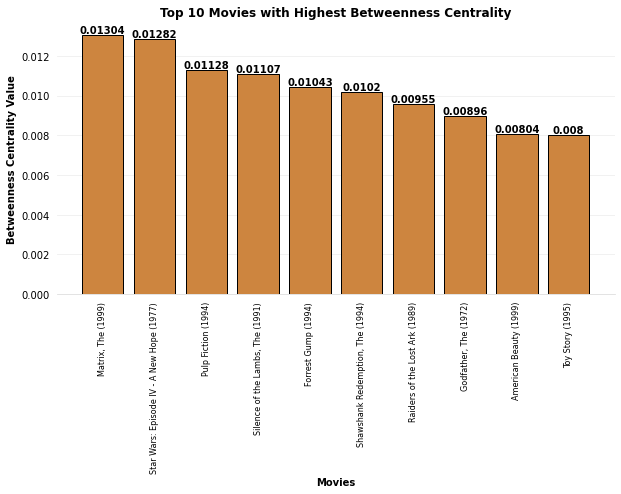

In [32]:

fig, ax = plt.subplots(figsize=(10, 5))


# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=betweenness_centrality_titles,
    height=betweenness_centrality_val,
    edgecolor='black',
    color='peru'
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# # Grab the color of the bars so we can make the
# # text the same color.
bar_color = bars[0].get_facecolor()

# # Add text annotations to the top of the bars.
# # Note, you'll have to adjust this slightly (the 0.3)
# # with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.0001,
      round(bar.get_height(), 5),
      horizontalalignment='center',
      color='black',
      weight='bold'
  )

ax.tick_params(axis='x', rotation=90,labelsize=8)
ax.set_title("Top 10 Movies with Highest Betweenness Centrality", fontweight='bold')
ax.set_ylabel("Betweenness Centrality Value", fontweight='bold')
ax.set_xlabel("Movies", fontweight='bold')
plt.show()


#### Highest Degree Nodes

Here we can see the nodes with highest degrees.

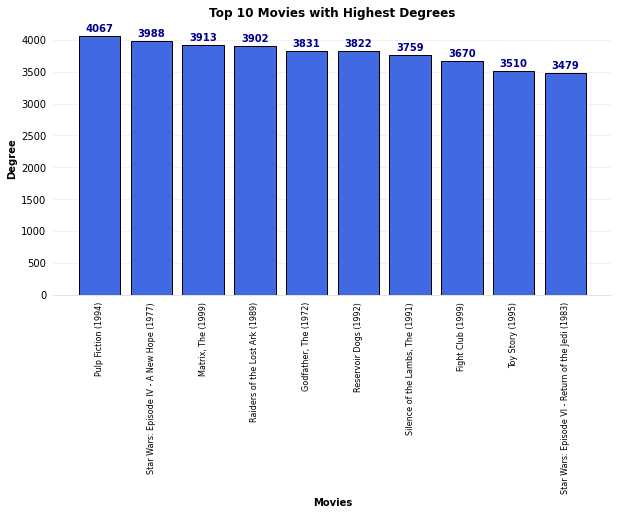

In [33]:
G_nodes = list(G.nodes())

nodes_deg = {}
for n in G_nodes:
    nodes_deg[n] = G.degree(n)
    
nodes_deg_counter = Counter(nodes_deg)

    

top_movies_m = []
top_movies_r = []
top_movies_d = []

for k, v in nodes_deg_counter.most_common(10):
    
    title = str(movies[movies['movieId']==k]['title'].values[0])
    average_rating = str(movies[movies['movieId']==k]['average_rating'].values[0])
    
    top_movies_m.append(title)
    top_movies_r.append(average_rating)
    top_movies_d.append(v)
    
    

fig, ax = plt.subplots(figsize=(10, 5))


# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=top_movies_m,
    height=top_movies_d,
    edgecolor='black',
    color='royalblue'
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 70,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='darkblue',
      weight='bold'
  )

ax.tick_params(axis='x', rotation=90,labelsize=8)
ax.set_title("Top 10 Movies with Highest Degrees", fontweight='bold')
ax.set_ylabel("Degree", fontweight='bold')
ax.set_xlabel("Movies", fontweight='bold')
plt.show()


In [158]:
def edges_genres(movieId):
    
    movies_pulp_fiction = []
    for e in G.edges():
        if e[0]==movieId:
            movies_pulp_fiction.append(e[1])

        if e[1]==movieId:
            movies_pulp_fiction.append(e[0])
            
    genres_pulp_fiction = []
    for i in movies_pulp_fiction:
        genres_i = movies[movies['movieId']==i]['genres_split']
        for g in genres_i:
            for k in g:
                genres_pulp_fiction.append(k)
                
    genres_pulp_fiction_count = Counter(genres_pulp_fiction)

    genres_pulp_fiction_count_percent = sorted([(i, genres_pulp_fiction_count[i] / len(genres_pulp_fiction) * 100.0) for i in genres_pulp_fiction_count],key = lambda x: x[1],reverse=True)
    
    movie_title = movies[movies['movieId']==movieId]['title'].to_string(index=False)
    genres = movies[movies['movieId']==movieId]['genres_split'].to_string(index=False)

    return movie_title,genres_pulp_fiction_count_percent,genres
              

In [163]:
# Pulp Fiction
movie_title,genres_pulp_fiction_count_percent,genres = edges_genres(296)
print(movie_title)
print(genres_pulp_fiction_count_percent)
print(genres)

# Star Wars: Episode IV - A New Hope (1977)
movie_title,genres_pulp_fiction_count_percent,genres = edges_genres(260)
print(movie_title)
print(genres_pulp_fiction_count_percent)
print(genres)


# Matrix, The (1999)
movie_title,genres_pulp_fiction_count_percent,genres = edges_genres(2571)
print(movie_title)
print(genres_pulp_fiction_count_percent)
print(genres)

Pulp Fiction (1994)
[('Drama', 22.323200668546956), ('Comedy', 14.67669487099133), ('Thriller', 9.046275984539852), ('Action', 8.691110414708033), ('Romance', 7.521153243497336), ('Crime', 6.06915282565549), ('Adventure', 5.870677948396532), ('Sci-Fi', 4.53358403844145), ('Fantasy', 3.3009505902016087), ('Horror', 3.0189073435704588), ('Mystery', 2.924892928026742), ('Animation', 2.517497127337303), ('Children', 2.130993418990912), ('War', 2.026532957275671), ('Documentary', 1.5251227410425154), ('Musical', 1.462446464013371), ('IMAX', 0.9505902016086911), ('Western', 0.8670218322364984), ('Film-Noir', 0.4700720777185835), ('(no genres listed)', 0.07312232320066855)]
[Comedy, Crime, Drama, Thriller]
Star Wars: Episode IV - A New Hope (1977)
[('Drama', 20.316595030925676), ('Comedy', 14.571758045916763), ('Action', 9.372051577733515), ('Thriller', 8.774504665059231), ('Romance', 7.023797043715274), ('Adventure', 6.772198343641891), ('Crime', 5.640004193311668), ('Sci-Fi', 4.895691372261

For 3 main movies we showed their own genres and also the percentage of different genres which this node is connected to. So for instance the movie 'Pulp Fiction' has genres : [Comedy, Crime, Drama, Thriller] and the it is highly connected to nodes which their genres are : 'Drama', 'Comedy', 'Thriller' and 'Action'

In [180]:
print('Mean of Ratings:',np.round_(np.mean(movies['average_rating']),2))
for r,m in zip(top_movies_r, top_movies_m):
    print(m,':',np.round_(float(r),2))

Mean of Ratings: 4.26
Pulp Fiction (1994) : 4.62
Star Wars: Episode IV - A New Hope (1977) : 4.59
Matrix, The (1999) : 4.6
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : 4.48
Godfather, The (1972) : 4.67
Reservoir Dogs (1992) : 4.5
Silence of the Lambs, The (1991) : 4.49
Fight Club (1999) : 4.62
Toy Story (1995) : 4.36
Star Wars: Episode VI - Return of the Jedi (1983) : 4.53


Here we can see the rating of the high degree movies. We can see that they are all above the average rating.

#### Highest Degree Nodes in Each Genre 

Here we wanted to find the most important movies (in terms of degrees) for each genre.

In [189]:
genre_unique = np.unique(movies_genres_df['genres_split'] )

genre_vs_degree_top = pd.DataFrame({'genres_split' : [],'degree':[],'count':[]})

for g in genre_unique:
    res = movies_genres_df[movies_genres_df['genres_split'] == g].sort_values(by=['degree'],ascending=False).head(3)
    genre_vs_degree_top = pd.concat([genre_vs_degree_top,res])
    
genre_vs_degree_top[['genres_split','title']]

genres_split                                              title
13291  (no genres listed)                                             The OA
13370  (no genres listed)                  T2 3-D: Battle Across Time (1996)
13358  (no genres listed)                                             Cosmos
427                Action          Star Wars: Episode IV - A New Hope (1977)
3542               Action                                 Matrix, The (1999)
1696               Action  Raiders of the Lost Ark (Indiana Jones and the...
428             Adventure          Star Wars: Episode IV - A New Hope (1977)
1697            Adventure  Raiders of the Lost Ark (Indiana Jones and the...
0               Adventure                                   Toy Story (1995)
1               Animation                                   Toy Story (1995)
5483            Animation                                       Shrek (2001)
918             Animation                                     Aladdin (1992)
2                Children                                   Toy Story (1995)
1592             Children                  E.T. the Extra-Terrestrial (1982)
5484             Children                                       Shrek (2001)
479                Comedy                                Pulp Fiction (1994)
3                  Comedy                                   Toy Story (1995)
960                Comedy                                       Fargo (1996)
480                 Crime                                Pulp Fiction (1994)
1230                Crime                              Godfather, The (1972)
1577                Crime                              Reservoir Dogs (1992)
6535          Documentary                       Bowling for Columbine (2002)
8027          Documentary                               Super Size Me (2004)
8090          Documentary                             Fahrenheit 9/11 (2004)
481                 Drama                                Pulp Fiction (1994)
1231                Drama                              Godfather, The (1972)
3987                Drama                                  Fight Club (1999)
4                 Fantasy                                   Toy Story (1995)
1864              Fantasy                               Groundhog Day (1993)
6035              Fantasy  Lord of the Rings: The Fellowship of the Ring,...
2315            Film-Noir                           L.A. Confidential (1997)
1827            Film-Noir                                   Chinatown (1974)
5888            Film-Noir                            Mulholland Drive (2001)
931                Horror                   Silence of the Lambs, The (1991)
1734               Horror                                       Alien (1979)
3765               Horror                            Sixth Sense, The (1999)
10926                IMAX                                   Inception (2010)
600                  IMAX                              Lion King, The (1994)
10006                IMAX                            Dark Knight, The (2008)
921               Musical                                     Aladdin (1992)
1326              Musical                           Wizard of Oz, The (1939)
1553              Musical         Willy Wonka & the Chocolate Factory (1971)
1578              Mystery                              Reservoir Dogs (1992)
97                Mystery                        Seven (a.k.a. Se7en) (1995)
5406              Mystery                                     Memento (2000)
584               Romance                                Forrest Gump (1994)
3851              Romance                             American Beauty (1999)
1865              Romance                               Groundhog Day (1993)
429                Sci-Fi          Star Wars: Episode IV - A New Hope (1977)
3543               Sci-Fi                                 Matrix, The (1999)
1725               Sci-Fi  Star Wars: Episode VI - Return of the Jedi (1983)
482      

#### Highest Average Rating Nodes

In [28]:
movies_avg_rating_dict = movies_avg_rating.set_index('movieId').T.to_dict('list')

movie_deg_counter = Counter(movies_avg_rating_dict)


movie_rating_deg = []
for k, v in movie_deg_counter.most_common(10):
    
    title = str(movies[movies['movieId']==k]['title'].values[0])
    deg = G.degree(n)
    
    movie_rating_deg.append([title,v,deg])

print(tabulate(movie_rating_deg, headers=['Title', 'Rating','Degree']))

Title                                          Rating      Degree
---------------------------------------------  --------  --------
Tom and Huck (1995)                            [5.0]            1
Now and Then (1995)                            [5.0]            1
Cry, the Beloved Country (1995)                [5.0]            1
Lamerica (1994)                                [5.0]            1
Home for the Holidays (1995)                   [5.0]            1
Angels and Insects (1995)                      [5.0]            1
Heidi Fleiss: Hollywood Madam (1995)           [5.0]            1
Anne Frank Remembered (1995)                   [5.0]            1
Chungking Express (Chung Hing sam lam) (1994)  [5.0]            1
Awfully Big Adventure, An (1995)               [5.0]            1


We can see that the highest rated movies are those with the lowest degree. That is because if a movie is famous and a lot of people have seen it, then it would definitely have some lower ratings as well and these ratings would diminish the overal degree.

In [195]:
corr_deg_rat = np.corrcoef(movies['degree'],movies['average_rating'])[0,1]

print(corr_deg_rat)

0.05106013969249014


Here we can see that there is no relation between rating and degree

#### Year VS Degree & Rating

It is interesting to see the trends of the degrees and rating over time.

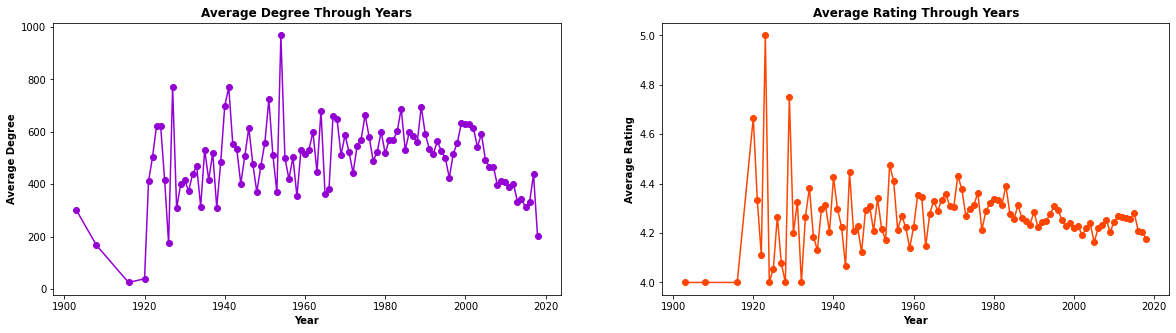

In [34]:
year_vs_deg = movies.groupby('year')['degree'].mean().reset_index()
year_vs_deg = year_vs_deg[ year_vs_deg['year'] != 0 ]

fig = plt.figure(figsize = (20, 5))

plt.subplot(121)

plt.plot(year_vs_deg['year'],year_vs_deg['degree'],'-o', color = 'darkviolet')
#plt.xticks(rotation=90)
plt.title("Average Degree Through Years", fontweight='bold')
plt.ylabel("Average Degree", fontweight='bold')
plt.xlabel("Year", fontweight='bold')

plt.subplot(122)

year_vs_deg = movies.groupby('year')['average_rating'].mean().reset_index()
year_vs_deg = year_vs_deg[ year_vs_deg['year'] != 0 ]

plt.plot(year_vs_deg['year'],year_vs_deg['average_rating'],'-o', color = 'orangered')
#plt.xticks(rotation=90)
plt.title("Average Rating Through Years", fontweight='bold')
plt.ylabel("Average Rating", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.show()

#### Genres vs Degree

And here we can compare different genres based on the average degree. We can see that movies with no genre and the genre 'Documentary' have the elast average degree.

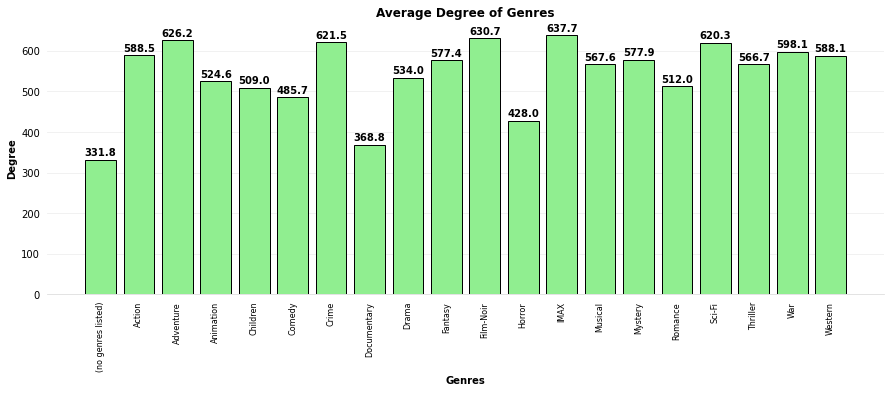

In [35]:
genre_vs_deg = movies_genres_df.groupby('genres_split')['degree'].mean().reset_index()
    

fig, ax = plt.subplots(figsize=(15, 5))


# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=genre_vs_deg['genres_split'],
    height=genre_vs_deg['degree'],
    edgecolor='black',
    color='lightgreen'
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 10,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      weight='bold'
  )

ax.tick_params(axis='x', rotation=90,labelsize=8)
ax.set_title("Average Degree of Genres", fontweight='bold')
ax.set_ylabel("Degree", fontweight='bold')
ax.set_xlabel("Genres", fontweight='bold')
plt.show()


### Genre vs Runtime

Comparing genres based on the duration of the movie.

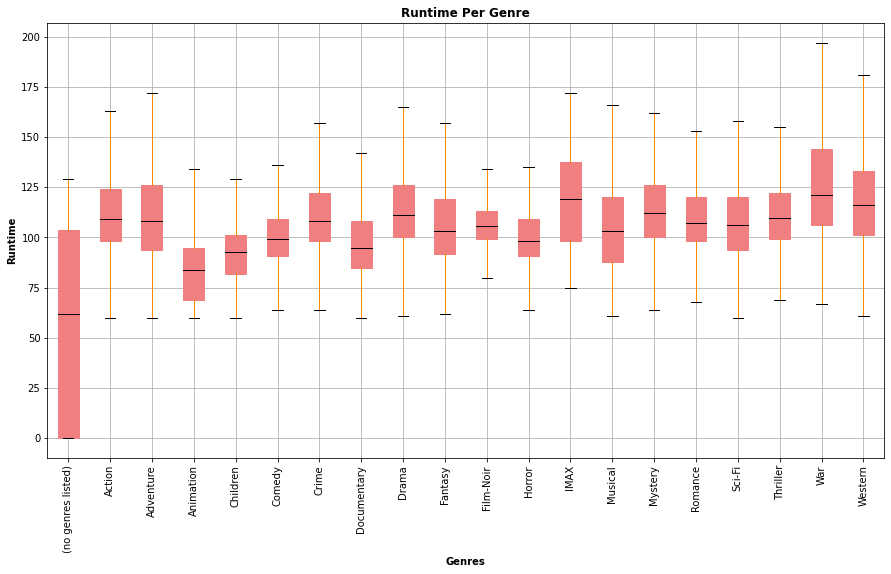

In [36]:
props = dict(boxes="lightcoral", whiskers="darkorange", medians="black", caps="black")
axes = movies_genres_df.plot.box(column='Runtime',by='genres_split',figsize=(15,8), rot=90,showfliers=False,color=props, patch_artist=True)
plt.grid(True)
plt.title('Runtime Per Genre', fontweight='bold')
plt.xlabel("Genres", fontweight='bold')
plt.ylabel("Runtime", fontweight='bold')
plt.show()


### Genre vs Country

Here we wanted to find the most movie making countries in each genre. As we can guess some famous countries are repeated in all different genres but there are some surprises for some genres. For instance we can see 'Argentina' is among the important countries in the genre 'IMAX' .

In [38]:
genre_vs_country = movies_genres_df.groupby(['genres_split','Country']).count().reset_index()
genre_vs_country = genre_vs_country[['genres_split','Country','title']]
genre_vs_country.columns = ['genres_split','Country','count']

In [39]:
genre_unique = np.unique(genre_vs_country['genres_split'] )

genre_vs_country_top = pd.DataFrame({'genres_split' : [],'Country':[],'count':[]})

for g in genre_unique:
    res = genre_vs_country[genre_vs_country['genres_split'] == g].sort_values(by=['count'],ascending=False).head(5)
    genre_vs_country_top = pd.concat([genre_vs_country_top,res])
    
    
Country_list = list(np.unique(genre_vs_country_top['Country']))
genre_list = list(np.unique(genre_vs_country_top['genres_split']))

In [40]:
Country_dict ={}
i=0
for c in Country_list:
    Country_dict[c] = i
    i += 1
    
#-------------------------

genre_dict ={}
i=0
for g in genre_list:
    genre_dict[g] = i
    i += 1
    

In [41]:
country_top_num = genre_vs_country_top['Country'].replace(Country_dict)
genre_top_num = genre_vs_country_top['genres_split'].replace(genre_dict)

genre_vs_country_top_num = pd.concat([genre_top_num,country_top_num],axis=1)

xticks_genre = [i for i in range(len(genre_list))]
xticks_Country = [i for i in range(len(Country_list))]

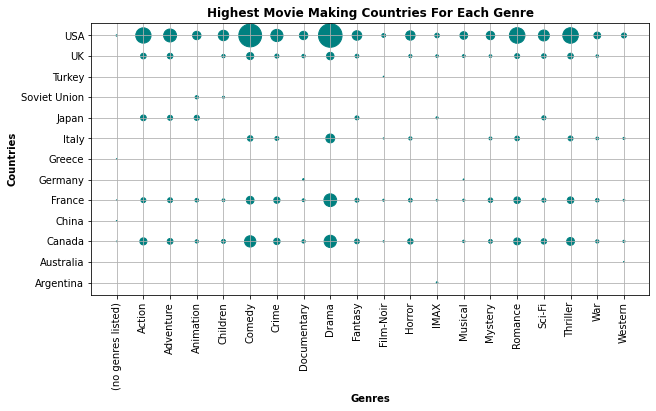

In [42]:
fig = plt.figure(figsize = (10, 5))

plt.scatter(genre_vs_country_top_num["genres_split"],
            genre_vs_country_top_num["Country"],s=genre_vs_country_top['count']*0.45,c='teal')

plt.xticks(xticks_genre, genre_list, rotation=90) 
plt.yticks(xticks_Country, Country_list)
plt.title('Highest Movie Making Countries For Each Genre', fontweight='bold')
plt.xlabel("Genres", fontweight='bold')
plt.ylabel("Countries", fontweight='bold')

plt.grid()


#### Edges Between the Genres

We wanted to find which pair of genres have the most between edges. Here we can see that there are a lot of 'Comedy' movies which are connected to 'Drama' movies and this pair has the highest number of edges.

In [47]:
edges_between_genres = []
for e in G.edges():
    g0 = movies_genres_df[movies_genres_df['movieId']== e[0] ]['genres_split'].tolist()
    g1 = movies_genres_df[movies_genres_df['movieId']== e[1] ]['genres_split'].tolist()  
    
    if set(g0) & set(g1) == set():
        for i in g0:
            for j in g1:
                edges_between_genres.append((i,j))
                edges_between_genres.append((j,i))
                
from collections import Counter
count_edges_between_genres  = Counter(edges_between_genres)       

In [57]:
count_edges_between_genres.most_common(10)

[(('Comedy', 'Drama'), 211356),
 (('Drama', 'Comedy'), 211356),
 (('Action', 'Drama'), 126949),
 (('Drama', 'Action'), 126949),
 (('Comedy', 'Thriller'), 126598),
 (('Thriller', 'Comedy'), 126598),
 (('Adventure', 'Drama'), 113753),
 (('Drama', 'Adventure'), 113753),
 (('Comedy', 'Action'), 110816),
 (('Action', 'Comedy'), 110816)]

#### Similar Genres

As we know our movies can have multiple genres. So a movie can be 'Drama' and 'War'. Here we found the most repeated ones and we can see 'Drama' and 'Comedy' as the first pair followed by the pair 'Drama' and 'Romance'

In [74]:
genres_together = []
for index, row in movies.iterrows():
    for i in row['genres_split']:
        for j in row['genres_split']:
            if i != j:
                genres_together.append((i,j))
                genres_together.append((j,i))
            
            
count_genres_together  = Counter(genres_together)

In [75]:
count_genres_together.most_common(10)

[(('Comedy', 'Drama'), 1304),
 (('Drama', 'Comedy'), 1304),
 (('Drama', 'Romance'), 1296),
 (('Romance', 'Drama'), 1296),
 (('Comedy', 'Romance'), 1076),
 (('Romance', 'Comedy'), 1076),
 (('Drama', 'Thriller'), 1062),
 (('Thriller', 'Drama'), 1062),
 (('Action', 'Thriller'), 866),
 (('Thriller', 'Action'), 866)]

# 3. Community Detection

We have created the the communities by using Louvain method from Networkx package.

In [7]:
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

The code for giving only one genres for every movies. And set genres as node attribute.

In [8]:
def first(x):
    y=x[0]
    return y 


movies1=movies.reset_index()
movies1['genres_first']=[first(x) for x in movies1.genres_split]

codes, uniques = pd.factorize(movies1.genres_first)
movies2=pd.DataFrame([codes,movies1.movieId]).T.rename(columns={0: "genre", 1: "movieId"})

nodes_attr = movies2.set_index('movieId').to_dict(orient = 'index')
nx.set_node_attributes(G, nodes_attr)

## TF-IDF on Tags

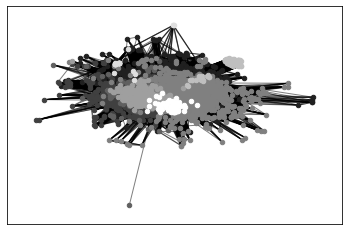

Modularity: 0.2076256643731186
Number of communities in Film-network: 8
Community number 0 has 1200 nodes
Community number 1 has 1100 nodes
Community number 2 has 690 nodes
Community number 3 has 1987 nodes
Community number 4 has 476 nodes
Community number 5 has 150 nodes
Community number 6 has 25 nodes
Community number 7 has 132 nodes


In [9]:
## Finding communities with the Python Louvain-algorithm
# First compute the best partition

partition = community_louvain.best_partition(G)
# Drawing DC-network with communities
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

## Defining nodes for each community
Films = []
for i in range(len(np.unique(list(partition.values())))): 
    i_com = []
    for j in range(len(list(partition.values()))):
        if list(partition.values())[j] == i:
            i_com.append(list(partition.keys())[j])
    Films.append(i_com)

## Modularity
print("Modularity:", nx_comm.modularity(G, Films))

## Number and size of communities
N_com = len(set(partition.values()))
print("Number of communities in Film-network:", N_com)
for i in range(N_com):
    res = 0
    for k in partition:
        if partition[k] == i:
            res += 1
    print("Community number", i, "has", res, "nodes")

First we have created the TF-IDFs for the tags words.

In [10]:
com_size = []
for i in range(len(Films)):
    com_size.append(len(Films[i]))
# Getting index for the 10 largest communities
com_index = sorted(range(len(com_size)), key=lambda i: -com_size[i])
## Getting all text from each community
dc_com_tokens = []
for c_ind in com_index:
    com_i_tokens = []
    for i in range(len(Films[c_ind])):
        com_i_tokens.extend(tokenizer.tokenize(tags.tag[c_ind])) 
    com_i_tokens = [w.lower() for w in com_i_tokens]
    com_i_tokens = [lemmatizer.lemmatize(w) for w in com_i_tokens]
    dc_com_tokens.append(com_i_tokens)

## Calculating TF list for each community
TF_com_list = []
for i in range(len(dc_com_tokens)):
    fdist = FreqDist(dc_com_tokens[i])
    TF_com_list.append(fdist)
    #print(f"Top 5 words for community: {i}")
    #print(fdist.most_common(5))

## Calculating IDF for all words in all lists
# Total documents
N = len(dc_com_tokens)
# All unique words
unique_words = list(set(dc_com_tokens[0]))
for i in range(1,N):
    com_i_u_w = set(dc_com_tokens[i])
    unique_words.extend(list(com_i_u_w))
IDF_dict = dict()
for word in unique_words:
    nd = 0
    for i in range(N):
        if word in dc_com_tokens[i]:
            nd += 1
    IDF_dict[word] = np.log(N/nd)

## Calculating TF-IDF
w = 1000
c = 0
TF_IDF_all_com = []
for c in range(N):
    TF_IDF = dict()
    for w in range(len(list(TF_com_list[c].keys()))):
        tf_idf = TF_com_list[c][list(TF_com_list[c].keys())[w]]*IDF_dict[list(TF_com_list[c].keys())[w]]
        TF_IDF[list(TF_com_list[c].keys())[w]] = tf_idf
    TF_IDF_all_com.append(TF_IDF)

## Printing top 10 TF-IDF words for each community 
for c in range(N):
    print(f"TF-IDF words for community: {c}")
    print(dict(sorted(TF_IDF_all_com[c].items(), key=lambda item: -item[1])))

TF-IDF words for community: 0
{'boxing': 4131.850343317834, 'story': 4131.850343317834}
TF-IDF words for community: 1
{'funny': 2495.329850015803}
TF-IDF words for community: 2
{'highly': 2287.3856958478195, 'quotable': 2287.3856958478195}
TF-IDF words for community: 3
{'will': 1434.8146637590867, 'ferrell': 1434.8146637590867}
TF-IDF words for community: 4
{'mma': 989.8141738396018}
TF-IDF words for community: 5
{'tom': 311.9162312519754, 'hardy': 311.9162312519754}
TF-IDF words for community: 6
{'leonardo': 274.48628350173834, 'dicaprio': 274.48628350173834}
TF-IDF words for community: 7
{'drug': 51.986038541995896}


## TF-IDF on Storyline

The code giving the result when we created the TF-IDFs for the storylines, which was given in movie final csv.

In [12]:
#final_movie=pd.read_csv('movies_final.csv')
final_movie = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\movies_final.csv')

In [14]:
com_size = []
for i in range(len(Films)):
    com_size.append(len(Films[i]))
# Getting index for the 10 largest communities
com_index = sorted(range(len(com_size)), key=lambda i: -com_size[i])
## Getting all text from each community
dc_com_tokens = []
for c_ind in com_index:
    com_i_tokens = []
    for i in range(len(Films[c_ind])):
        com_i_tokens.extend(tokenizer.tokenize(final_movie.Storyline[c_ind])) 
    com_i_tokens = [w.lower() for w in com_i_tokens]
    com_i_tokens = [lemmatizer.lemmatize(w) for w in com_i_tokens]
    dc_com_tokens.append(com_i_tokens)

## Calculating TF list for each community
TF_com_list = []
for i in range(len(dc_com_tokens)):
    fdist = FreqDist(dc_com_tokens[i])
    TF_com_list.append(fdist)
    #print(f"Top 5 words for community: {i}")
    #print(fdist.most_common(5))

## Calculating IDF for all words in all lists
# Total documents
N = len(dc_com_tokens)
# All unique words
unique_words = list(set(dc_com_tokens[0]))
for i in range(1,N):
    com_i_u_w = set(dc_com_tokens[i])
    unique_words.extend(list(com_i_u_w))
IDF_dict = dict()
for word in unique_words:
    nd = 0
    for i in range(N):
        if word in dc_com_tokens[i]:
            nd += 1
    IDF_dict[word] = np.log(N/nd)

## Calculating TF-IDF
w = 1000
c = 0
TF_IDF_all_com = []
for c in range(N):
    TF_IDF = dict()
    for w in range(len(list(TF_com_list[c].keys()))):
        tf_idf = TF_com_list[c][list(TF_com_list[c].keys())[w]]*IDF_dict[list(TF_com_list[c].keys())[w]]
        TF_IDF[list(TF_com_list[c].keys())[w]] = tf_idf
    TF_IDF_all_com.append(TF_IDF)

## Printing top 10 TF-IDF words for each community 
for c in range(N):
    print(f"TF-IDF words for community: {c}")
    print(dict(sorted(TF_IDF_all_com[c].items(), key=lambda item: -item[1])))

TF-IDF words for community: 0
{'with': 8263.700686635668, 'his': 5509.133791090445, 'george': 4131.850343317834, 'bank': 4131.850343317834, 'must': 4131.850343317834, 'deal': 4131.850343317834, 'daughter': 4131.850343317834, 'pregnancy': 4131.850343317834, 'also': 4131.850343317834, 'wife': 4131.850343317834, 's': 3897.8154514686, 'not': 2754.5668955452225, 'only': 2754.5668955452225, 'but': 2754.5668955452225}
TF-IDF words for community: 1
{'cowboy': 2495.329850015803, 'doll': 2495.329850015803, 'is': 2495.329850015803, 'profoundly': 2495.329850015803, 'threatened': 2495.329850015803, 'jealous': 2495.329850015803, 'spaceman': 2495.329850015803, 'action': 2495.329850015803, 'figure': 2495.329850015803, 'supplants': 2495.329850015803, 'him': 2495.329850015803, 'top': 2495.329850015803, 'toy': 2495.329850015803, 'boy': 2495.329850015803, 'bedroom': 2495.329850015803, 'new': 1663.5532333438687, 'when': 1176.9951036140715, 'in': 1176.9951036140715, 's': 1176.9951036140715, 'a': 640.9506845

## Connection Between the Found Communities and the Genres

We have compared the communities and the genres to find out is there any overlapping between the genres and the communities.

In [15]:
from itertools import groupby

# Sort the nodes by their role (this is required for the groupby to work)
sorted_by_role = sorted(G.nodes(data=True), key=lambda node_data: node_data[1]["genre"])
# Group objects with same role together
grouped = groupby(sorted_by_role, key=lambda node_data: node_data[1]["genre"])

subgraphs = dict()
for key, group in grouped:
     nodes_in_group, _ = zip(*list(group))  # We don't care about the data here, only the node names
     subgraphs[key] = G.subgraph(nodes_in_group)

In [16]:
empty={}
for x in subgraphs.keys():
    sub={}
    values=[]
    keys=range(len(list(subgraphs[x].nodes)))
    for i in range(len(list(subgraphs[x].nodes))):
        values.append(len(subgraphs[x].edges(list(subgraphs[x].nodes)[i])))
    for i in keys:
        sub[i] = x
    for z in range(len(list(subgraphs[x].nodes))):
        sub[list(subgraphs[x].nodes)[z]]=sub.pop(z)
        empty.update(sub)

We take a look at is there any connection between the created communities and the genres. The Dataframe show us there are no connection between them.

In [17]:
part=pd.DataFrame.from_dict(partition,orient='index')
genre=pd.DataFrame.from_dict(empty,orient='index')
Genres=pd.DataFrame(pd.merge(part, genre, left_index=True, right_index=True).rename(columns={'0_x':'community','0_y':'genre'}).groupby('community').value_counts(),columns=['number of genre'])
Genres

number of genre
community genre                 
0         3                  362
          1                  237
          2                  197
          10                 113
          4                   80
...                          ...
7         0                    8
          2                    6
          4                    5
          10                   3
          18                   1

[114 rows x 1 columns]

# 4. Multi-label Classification

Creating a multi-label classification model to predict genres based on storylines

## Preparing the data

Preparing the data by one-hot-encoding the target, the genre variable

In [4]:
#### One hot encoding data

## Taking only relevant columns
final_movie = pd.read_csv('D:\DTU\Large Files\Social Graphs\Project\ml-latest-small\\movies_final.csv')
class_data = final_movie[["Storyline", "genres"]]


## Splitting genres into lists
genres = []
for i in range(len(class_data["genres"])):
    genres.append(class_data["genres"][i].split("|"))

## One hot encoding
one_hot = MultiLabelBinarizer()
ohe_genres = pd.DataFrame(one_hot.fit_transform(genres), columns = one_hot.classes_)

## Adding to dataframe
class_data_ohe = pd.concat([class_data, ohe_genres], axis=1, join='inner')

## Removing nan
class_data_ohe = class_data_ohe.dropna()

## Text processing

Preprocessing the input, the storyline text, by tokenizing, removing stop words and stemming  

In [5]:
### Downloading stem and stopwords
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonknudsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
### Preprocess function
def preprocessing(text):
   # Tokenize all words longer than 1 letter
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 1) ] 
   tokens = map(str.lower, tokens) # unique words
   # Stems all tokens (stop words ignored)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

In [7]:
vectorizer_tf = TfidfVectorizer(tokenizer=preprocessing, stop_words=None, max_df=0.75, max_features=2000, lowercase=False, ngram_range=(1,3))
# Initial parameters:
# max_feature=1000
# n_gram =(1,2)
# max_df=0.75

## Creating train and test data sets

Splitting the input and target into train and test sets

In [9]:
### Creating data

## Features, storylines  
Xfeatures = vectorizer_tf.fit_transform(class_data_ohe.Storyline).toarray()

## Classification classes, genres
y = class_data_ohe[['(no genres listed)', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

## Splitting in train and test
X_train,X_test,y_train,y_test = train_test_split(Xfeatures,y,test_size=0.3,random_state=42)

## Building model

Building a Multinomial Naive Bayes classification model to a classifier chain to handle multi-labels 

In [10]:
### Defining model
def build_model(model,mlb_estimator,xtrain,ytrain,xtest,ytest):
    clf = mlb_estimator(model)
    clf.fit(xtrain,ytrain)
    clf_predictions = clf.predict(xtest)
    acc = accuracy_score(ytest,clf_predictions)
    ham = hamming_loss(ytest,clf_predictions)
    result = {"accuracy:":acc,"hamming_score":ham}
    return result, clf

In [11]:
### Model 2
clf_chain_model, clf_chain = build_model(MultinomialNB(),ClassifierChain,X_train,y_train,X_test,y_test)
clf_chain_model

{'accuracy:': 0.1568287037037037, 'hamming_score': 0.10081018518518518}

## Evaluation

Evaluating the model with different scores, and comparing to baseline models

In [16]:
### Calculating different evaluation scores - Compared to baseline models

## CLF model predictions for test data
clf_predictions = clf_chain.predict(X_test)
# Initializing  
TP_each = 0
TN_each = 0
FP_each = 0
FN_each = 0
T_exact = 0
# For loop through all predictions   
for i in range(1728):
    if((y_test.to_numpy()[i] == clf_predictions[i]).all()):
        T_exact += 1
    for j in range(20):
        if(y_test.to_numpy()[i][j] == 1 and clf_predictions[i][j] == 1):
            TP_each += 1
        if(y_test.to_numpy()[i][j] == 0 and clf_predictions[i][j] == 0):
            TN_each += 1
        if(y_test.to_numpy()[i][j] == 0 and clf_predictions[i][j] == 1):
            FP_each += 1 
        if(y_test.to_numpy()[i][j] == 1 and clf_predictions[i][j] == 0):
            FN_each += 1   
# Printing scores
print("Clf model predictions")
print("Exact matches, accuracy:", T_exact/1728)
print("Each genre-match, accuracy:", (TP_each+TN_each)/(TP_each+TN_each+FP_each+FN_each))
print("Each genre-match, precision:", (TP_each)/(TP_each+FP_each))
print("Each genre-match, recall:", (TP_each)/(TP_each+FN_each))
print("Each genre-match, F1:", (2*TP_each)/(2*TP_each+FP_each+FN_each))

## Baseline model, all zeros (no genre predicted for any movie)
base_predictions = np.zeros((1728,20))
# Initializing  
TP_each_b = 0
TN_each_b = 0
FP_each_b = 0
FN_each_b = 0
T_exact_b = 0
# For loop through all predictions   
for i in range(1728):
    if((y_test.to_numpy()[i] == base_predictions[i]).all()):
        T_exact_b += 1
    for j in range(20):
        if(y_test.to_numpy()[i][j] == 1 and base_predictions[i][j] == 1):
            TP_each_b += 1
        if(y_test.to_numpy()[i][j] == 0 and base_predictions[i][j] == 0):
            TN_each_b += 1
        if(y_test.to_numpy()[i][j] == 0 and base_predictions[i][j] == 1):
            FP_each_b += 1
        if(y_test.to_numpy()[i][j] == 1 and base_predictions[i][j] == 0):
            FN_each_b += 1
# Printing scores
print("")
print("Baseline zero-model predictions")
print("Exact matches, accuracy:", T_exact_b/1728)
print("Each genre-match, accuracy:", (TP_each_b+TN_each_b)/(TP_each_b+TN_each_b+FP_each_b+FN_each_b))
print("Each genre-match, precision: '0', none predicted positive")
print("Each genre-match, recall:", (TP_each_b)/(TP_each_b+FN_each_b))
print("Each genre-match, F1:", (2*TP_each_b)/(2*TP_each_b+FP_each_b+FN_each_b))

## Baseline model, all ones (all genres predicted for all movies)
base1_predictions = np.ones((1728,20))
# Initializing  
TP_each_b1 = 0
TN_each_b1 = 0
FP_each_b1 = 0
FN_each_b1 = 0
T_exact_b1 = 0
# For loop through all predictions   
for i in range(1728):
    if((y_test.to_numpy()[i] == base1_predictions[i]).all()):
        T_exact_b1 += 1
    for j in range(20):
        if(y_test.to_numpy()[i][j] == 1 and base1_predictions[i][j] == 1):
            TP_each_b1 += 1
        if(y_test.to_numpy()[i][j] == 0 and base1_predictions[i][j] == 0):
            TN_each_b1 += 1
        if(y_test.to_numpy()[i][j] == 0 and base1_predictions[i][j] == 1):
            FP_each_b1 += 1
        if(y_test.to_numpy()[i][j] == 1 and base1_predictions[i][j] == 0):
            FN_each_b1 += 1
# Printing scores
print("")
print("Baseline ones-model predictions")
print("Exact matches, accuracy:", T_exact_b1/1728)
print("Each genre-match, accuracy:", (TP_each_b1+TN_each_b1)/(TP_each_b1+TN_each_b1+FP_each_b1+FN_each_b1))
print("Each genre-match, precision:", (TP_each_b1)/(TP_each_b1+FP_each_b1))
print("Each genre-match, recall:", (TP_each_b1)/(TP_each_b1+FN_each_b1))
print("Each genre-match, F1:", (2*TP_each_b1)/(2*TP_each_b1+FP_each_b1+FN_each_b1))

Clf model predictions
Exact matches, accuracy: 0.1568287037037037
Each genre-match, accuracy: 0.8991898148148149
Each genre-match, precision: 0.6420176297747306
Each genre-match, recall: 0.32258858267716534
Each genre-match, F1: 0.42941369145103175

Baseline zero-model predictions
Exact matches, accuracy: 0.0
Each genre-match, accuracy: 0.8824074074074074
Each genre-match, precision: '0', none predicted positive
Each genre-match, recall: 0.0
Each genre-match, F1: 0.0

Baseline ones-model predictions
Exact matches, accuracy: 0.0
Each genre-match, accuracy: 0.1175925925925926
Each genre-match, precision: 0.1175925925925926
Each genre-match, recall: 1.0
Each genre-match, F1: 0.2104391052195526


We see our model performs better than both baseline models within all the evaluation scores, except for the recall evaluation to the ones-model. But this will naturally always be 100% for a all ones-model, since it doesn't predict any zeros

## Prediction example

An example of a prediction
With this example (Toy Story), we see it has 5 genres, and the model predicts one of them correctly, Comedy 

In [18]:
ex1 = class_data_ohe['Storyline'].iloc[0]
vec_example = vectorizer_tf.transform([ex1])
clf_chain.predict(vec_example)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [19]:
class_data_ohe.loc[0]

Storyline             A cowboy doll is profoundly threatened and jea...
genres                      Adventure|Animation|Children|Comedy|Fantasy
(no genres listed)                                                    0
Action                                                                0
Adventure                                                             1
Animation                                                             1
Children                                                              1
Comedy                                                                1
Crime                                                                 0
Documentary                                                           0
Drama                                                                 0
Fantasy                                                               1
Film-Noir                                                             0
Horror                                                          